# Movie Box Office prediction with sklearn

### Libraries and settings

In [61]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

### Import the movie data

In [62]:
imdb = pd.read_csv('data/imdb_movies.csv')
budgets = pd.read_csv('data/movie_budgets_and_revenues.csv')

# 2. Normalize title columns for merging
imdb = imdb.rename(columns={'names': 'movie_name'})
budgets = budgets.rename(columns={'Movie Name': 'movie_name'})

imdb['movie_name'] = imdb['movie_name'].str.lower().str.strip()
budgets['movie_name'] = budgets['movie_name'].str.lower().str.strip()

# 3. Merge on movie_name (inner join to keep only matches)
df = pd.merge(imdb, budgets, on='movie_name', how='inner')

# Save the merged DataFrame as a CSV file
df.to_csv('data/movies_data.csv', index=False)

# 4. Drop any rows with missing values and remove exact duplicates
df = df.dropna().drop_duplicates()

# 5. Quick sanity check
print(df.shape)
df.head(3)


(4098, 17)


,movie_name,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country,Number,Release Date,Budget,Domestic Gross,Worldwide Gross
0,creed iii,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU,771,"Mar 1, 2023","$75,000,000","$156,248,615","$274,448,615"
1,avatar: the way of water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU,2,"Dec 9, 2022","$460,000,000","$684,075,767","$2,317,514,386"
2,the super mario bros. movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU,451,"Apr 4, 2023","$100,000,000","$574,934,330","$1,361,553,421"


In [63]:
df.columns

Index(['movie_name', 'date_x', 'score', 'genre', 'overview', 'crew',
       'orig_title', 'status', 'orig_lang', 'budget_x', 'revenue', 'country',
       'Number', 'Release Date', 'Budget', 'Domestic Gross',
       'Worldwide Gross'],
      dtype='object')

In [64]:
# Drop “_x” duplicate columns from the merge, e.g. budget_x, date_x, etc.
to_drop = [c for c in df.columns if c.endswith('_x')]
df = df.drop(columns=to_drop)

# (Optional) If you also have “_y” duplicates and want to keep only one copy:
# to_drop_y = [c for c in df.columns if c.endswith('_y')]
# df = df.drop(columns=to_drop_y)

# Rename the remaining columns for consistency
df = df.rename(columns={
    'Budget': 'budget',
    'Worldwide Gross': 'worldwide_gross',
    'Domestic Gross': 'domestic_gross',
    'Release Date': 'release_date',
    'Number': 'number',
})

# Sanity check
print(df.columns.tolist())
print(df.shape)

df['budget'] = (
    df['budget']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)

# Clean the worldwide_gross column by removing dollar signs and commas
df['worldwide_gross'] = (
    df['worldwide_gross']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)

df['domestic_gross'] = (
    df['domestic_gross']
    .astype(str)
    .str.replace(r'[\$,]', '', regex=True)
    .astype(float)
)

# Filter out any movies with budget < $5,000,000
df = df[df['budget'] >= 5_000_000].reset_index(drop=True)

# Sanity check
print(f"Remaining entries: {df.shape[0]}")

# Drop duplicates and rows with missing values
df = df.drop_duplicates().dropna()

# Sanity check
print(f"Remaining entries after dropping duplicates and NA: {df.shape[0]}")

# Save the cleaned DataFrame to a CSV file
df.to_csv('data/cleaned_movies_data.csv', index=False)

# Sanity check to confirm the file is saved
print("Cleaned data saved to 'cleaned_movies_data.csv'")

['movie_name', 'score', 'genre', 'overview', 'crew', 'orig_title', 'status', 'orig_lang', 'revenue', 'country', 'number', 'release_date', 'budget', 'domestic_gross', 'worldwide_gross']
(4098, 15)
Remaining entries: 3632
Remaining entries after dropping duplicates and NA: 3632
Cleaned data saved to 'cleaned_movies_data.csv'


In [65]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(
    df[['score', 'budget']], 
    df['revenue'], 
    test_size=0.20, 
    random_state=42
)

In [66]:
from math import sqrt
from sklearn.metrics import r2_score

# train linear_model = LinearRegression()


linear_model = LinearRegression()

# Fit the model
linear_model.fit(X_train, y_train)
print("Train score: ", linear_model.score(X_train, y_train))
print("Test score: ", linear_model.score(X_test, y_test))

print("Train RMSE: ", sqrt(mean_squared_error(y_train, linear_model.predict(X_train))))
print("Test RMSE: ", sqrt(mean_squared_error(y_test, linear_model.predict(X_test))))

# Calculate R2 score for train and test sets
r2_train = r2_score(y_train, linear_model.predict(X_train))
r2_test = r2_score(y_test, linear_model.predict(X_test))

print("Train R2: ", r2_train)
print("Test R2: ", r2_test)

Train score:  0.39738958424207416
Test score:  0.41688383441257226
Train RMSE:  186082236.3286384
Test RMSE:  181925340.59930444
Train R2:  0.39738958424207416
Test R2:  0.41688383441257226


In [67]:
from math import sqrt

# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(X_train, y_train)
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))

print("Train RMSE: ", sqrt(mean_squared_error(y_train, random_forest_model.predict(X_train))))
print("Test RMSE: ", sqrt(mean_squared_error(y_test, random_forest_model.predict(X_test))))

# Calculate R2 score for train and test sets
r2_train = r2_score(y_train, random_forest_model.predict(X_train))
r2_test = r2_score(y_test, random_forest_model.predict(X_test))

print("Train R2: ", r2_train)
print("Test R2: ", r2_test)

Train score:  0.7385503739969015
Test score:  0.2982984857369665
Train RMSE:  122568991.36425696
Test RMSE:  199568440.1444931
Train R2:  0.7385503739969015
Test R2:  0.2982984857369665


['budget' 'score']
[0.69434523 0.30565477]


<Axes: ylabel='features'>

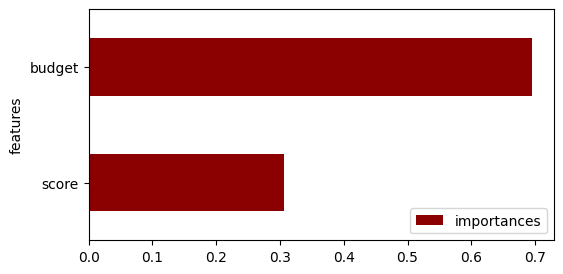

In [68]:
cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred', 
           figsize=(6,3))

### Train/Test splitting

# Create New Fetures

In [69]:
# 1. Build mapping dicts (you can inspect these to see which code goes to which category)
country_mapping = {country: idx+1 
                   for idx, country in enumerate(sorted(df['country'].unique()))}


# 2. Apply them
df['country_code'] = df['country'].map(country_mapping)


# 3. (Optional) Drop the originals if you don’t need them anymore
df = df.drop(columns=['country'])

# 4. Inspect
print("Country mapping:", country_mapping)
print(df[['country_code']].head())
df['crew_count'] = df['crew'].str.count(r'\|') + 1


Country mapping: {'AT': 1, 'AU': 2, 'BR': 3, 'CA': 4, 'CN': 5, 'DE': 6, 'ES': 7, 'FR': 8, 'GB': 9, 'HK': 10, 'ID': 11, 'IE': 12, 'IN': 13, 'IT': 14, 'JP': 15, 'KR': 16, 'MX': 17, 'NL': 18, 'RU': 19, 'SU': 20, 'TH': 21, 'TR': 22, 'US': 23, 'ZA': 24}
   country_code
0             2
1             2
2             2
3             2
4             2


In [70]:
# 1. Split genre names into lists (assuming genres are separated by commas or |)
df['genre_list'] = (
    df['genre']
    .fillna('')  # replace NaN with empty string
    .apply(lambda x: [genre.strip() for genre in x.split(',') if genre.strip()])
)

# 2. Build a mapping of each unique genre to a unique integer
unique_genres = sorted({genre for sublist in df['genre_list'] for genre in sublist})
genre_mapping = {genre: idx + 1 for idx, genre in enumerate(unique_genres)}

# 3. Create the summed feature
df['genre_code_sum'] = df['genre_list'] \
    .apply(lambda genres: sum(genre_mapping[genre] for genre in genres))

# 4. Keep the original single genre code for backward compatibility
df['genre_code'] = df['genre'].map({genre: genre_mapping.get(genre, 0) for genre in df['genre'].unique()})

# 5. Drop the original genre column
df = df.drop(columns=['genre'])

# 6. Inspect
print("Sample genre_code_sum values:")
print(df[['movie_name', 'genre_code_sum', 'genre_code']].head())

print("\nGenre mapping (first 10 entries):")
for genre, code in list(genre_mapping.items())[:10]:
    print(f"{genre!r}: {code}")

df['crew_count'] = df['crew'].str.count(r'\|') + 1

Sample genre_code_sum values:
                     movie_name  genre_code_sum  genre_code
0                     creed iii               8           0
1      avatar: the way of water              18           0
2   the super mario bros. movie              26           0
3          john wick: chapter 4              23           0
4  puss in boots: the last wish              26           0

Genre mapping (first 10 entries):
'Action': 1
'Adventure': 2
'Animation': 3
'Comedy': 4
'Crime': 5
'Documentary': 6
'Drama': 7
'Family': 8
'Fantasy': 9
'History': 10


In [71]:
# 1. Drop columns with duplicate names (keep first occurrence)
df = df.loc[:, ~df.columns.duplicated()]


# Sanity check
print(df.shape)
print("Columns:", df.columns.tolist())


(3632, 18)
Columns: ['movie_name', 'score', 'overview', 'crew', 'orig_title', 'status', 'orig_lang', 'revenue', 'number', 'release_date', 'budget', 'domestic_gross', 'worldwide_gross', 'country_code', 'crew_count', 'genre_list', 'genre_code_sum', 'genre_code']


In [72]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(
    df[['score', 'budget', 'country_code', 'genre_code', 'crew_count', 'genre_code_sum']], 
    df['revenue'], 
    test_size=0.20, 
    random_state=42
)

In [73]:
def model_performance(features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df = df.sample(frac=1, random_state=42)
    X, y = df[features], df['revenue']
    scores = cross_val_score(random_forest_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

In [74]:
features = ['score', 'budget', 'country_code', 'genre_code', 'crew_count', 'genre_code_sum']
model_performance(features, df)

CV results RMSE: [-1.88193740e+08 -1.77207870e+08 -2.15692246e+08 -1.96685836e+08
 -2.25094226e+08]
Mean RMSE: -200574783.6


In [75]:
def model_performance_linear(features, df, linear_model=LinearRegression()):
    df = df.sample(frac=1, random_state=42)
    X = df[features]  # Define X using the provided features
    y = df['revenue']  # Define y as the target variable
    scores = cross_val_score(linear_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

In [76]:
features = ['score', 'budget', 'country_code', 'genre_code', 'crew_count', 'genre_code_sum']
model_performance_linear(features, df)

CV results RMSE: [-1.82333860e+08 -1.68369391e+08 -1.93342525e+08 -1.69357713e+08
 -2.13381206e+08]
Mean RMSE: -185356939.0


# Feature Engineering

In [77]:
# Count number of words in the movie overview as a new feature
df['overview_word_count'] = (
    df['overview']
    .fillna('')              # handle NaNs
    .str.split()             # split on whitespace
    .str.len()               # count number of tokens
)

# (Optional) If you also want the title word count:
df['title_word_count'] = (
    df['movie_name']
    .fillna('')
    .str.split()
    .str.len()
)

# Sanity check
print(df[['overview_word_count', 'title_word_count']].head())


   overview_word_count  title_word_count
0                   82                 2
1                   50                 5
2                   41                 5
3                   47                 4
4                   47                 6


In [78]:
# 1. Split crew names into lists
df['crew_list'] = (
    df['crew']
    .fillna('')  # replace NaN with empty string
    .apply(lambda x: [name.strip() for name in x.split(',') if name.strip()])
)

# 2. Build a mapping of each unique crew member to a unique integer
unique_crew = sorted({member for sublist in df['crew_list'] for member in sublist})
crew_mapping = {name: idx + 1 for idx, name in enumerate(unique_crew)}

# 3. Create the summed feature
df['crew_code_sum'] = df['crew_list'] \
    .apply(lambda crew: sum(crew_mapping[name] for name in crew))

# 5. Inspect
print("Sample crew_code_sum values:")
print(df[['movie_name', 'crew_code_sum']].head())

print("\nCrew mapping (first 10 entries):")
for name, code in list(crew_mapping.items())[:10]:
    print(f"{name!r}: {code}")


Sample crew_code_sum values:
                     movie_name  crew_code_sum
0                     creed iii         339963
1      avatar: the way of water         361986
2   the super mario bros. movie         300490
3          john wick: chapter 4         300929
4  puss in boots: the last wish         365662

Crew mapping (first 10 entries):
'"Baby-O" O\'Dell': 1
'"Badge of Honor" Star Brett Chase': 2
'"German"': 3
'"Hollywood Dick" Moltisanti / Salvatore “Sally” Moltisanti': 4
'"Howling Mad" Murdock': 5
'"La Boeuf"': 6
'"Little Alice" Eklund': 7
'"Lucky" Ned Pepper': 8
'"Matron"': 9
'"Moon"': 10


In [79]:
# 1. Ensure 'release_date' is datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# 2a. Simple integer encoding: YYYYMMDD
# Handle NaT values by filling them with a default date (e.g., 1970-01-01) before conversion
df['release_date_int'] = (
    df['release_date']
    .fillna(pd.Timestamp('1970-01-01'))  # Replace NaT with a default date
    .dt.strftime('%Y%m%d')  # e.g., "20230521"
    .astype(int)
)

# Sanity check
print(df[['release_date', 'release_date_int']].head())


  release_date  release_date_int
0   2023-03-01          20230301
1   2022-12-09          20221209
2   2023-04-04          20230404
3   2023-03-22          20230322
4   2022-12-02          20221202


In [80]:
print("Columns:", df.columns.tolist())


Columns: ['movie_name', 'score', 'overview', 'crew', 'orig_title', 'status', 'orig_lang', 'revenue', 'number', 'release_date', 'budget', 'domestic_gross', 'worldwide_gross', 'country_code', 'crew_count', 'genre_list', 'genre_code_sum', 'genre_code', 'overview_word_count', 'title_word_count', 'crew_list', 'crew_code_sum', 'release_date_int']


In [81]:
features = ['budget','country_code', 'genre_code', 'crew_count', 'overview_word_count', 'title_word_count', 'crew_code_sum', 'release_date_int', 'genre_code_sum']
model_performance(features, df)
model_performance_linear(features, df)

CV results RMSE: [-1.98196309e+08 -1.73883668e+08 -1.99468472e+08 -1.83065526e+08
 -2.29953746e+08]
Mean RMSE: -196913544.2
CV results RMSE: [-1.85480474e+08 -1.70269051e+08 -1.95373444e+08 -1.71915086e+08
 -2.18124159e+08]
Mean RMSE: -188232442.8


In [82]:
# Berechnung der Ergebnisse für Random Forest
random_forest_model.fit(X_train, y_train)
rf_rmse_train = sqrt(mean_squared_error(y_train, random_forest_model.predict(X_train)))
rf_rmse_test = sqrt(mean_squared_error(y_test, random_forest_model.predict(X_test)))
rf_r2_train = random_forest_model.score(X_train, y_train)
rf_r2_test = random_forest_model.score(X_test, y_test)

# Berechnung der Ergebnisse für Lineare Regression
linear_model.fit(X_train, y_train)
lr_rmse_train = sqrt(mean_squared_error(y_train, linear_model.predict(X_train)))
lr_rmse_test = sqrt(mean_squared_error(y_test, linear_model.predict(X_test)))
lr_r2_train = linear_model.score(X_train, y_train)
lr_r2_test = linear_model.score(X_test, y_test)

# Ergebnisse in einer Tabelle zusammenfassen
results = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression'],
    'Train RMSE': [rf_rmse_train, lr_rmse_train],
    'Test RMSE': [rf_rmse_test, lr_rmse_test],
    'Train R²': [rf_r2_train, lr_r2_train],
    'Test R²': [rf_r2_test, lr_r2_test]
})

# Tabelle anzeigen
print(results)

               Model    Train RMSE     Test RMSE  Train R²   Test R²
0      Random Forest  8.821781e+07  1.881937e+08  0.864562  0.376008
1  Linear Regression  1.856693e+08  1.823339e+08  0.400061  0.414262


 Die lineare Regression zeigt zwar eine etwas bessere Performance auf den Testdaten (Test R² = 0.42) als der Random Forest (Test R² = 0.8), allerdings ist der Unterschied gering (0.04). Beim Training der Daten erzielt der Random Forest jedoch ein deutlich besseres Ergebnis (Train R² = 0.87) im Vergleich zur linearen Regression (Train R² = 0.40). Dies deutet darauf hin, dass der Random Forest das Training besser abbildet, aber möglicherweise stärker zum Overfitting neigt. Aufgrund dieser Tatsache wird absofort nur noch mit dem Random Forest weiter gearbeitet. 

<Axes: ylabel='features'>

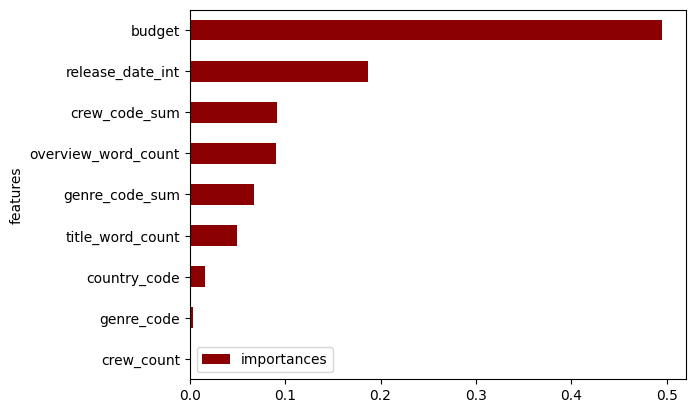

In [83]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.revenue)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

# Clean the Data Again and Another Feature engeneering part 

In [84]:
print('Total movies before data cleaning:', len(df))

# Remove missing values
df = df.dropna()

# Remove movies with a budget under 5 million
df = df[df['budget'] >= 10000000]

print('Total movies after data cleaning:', len(df))

Total movies before data cleaning: 3632
Total movies after data cleaning: 3309


In [85]:
df['budget_crew'] = df['budget'] / df['crew_code_sum']

In [86]:
# Load the IMDb movies data for 2000-2020
imdb_2000_2020 = pd.read_csv('data/imdb_movies_2000_-_2020.csv')
print(imdb_2000_2020.head())

  imdb_title_id                      title              original_title  year  \
0     tt0035423             Kate & Leopold              Kate & Leopold  2001   
1     tt0118589                    Glitter                     Glitter  2001   
2     tt0118694       In the Mood for Love            Fa yeung nin wah  2000   
3     tt0120202         Hollywood, Vermont              State and Main  2000   
4     tt0120263  Canzoni del secondo piano  Sånger från andra våningen  2000   

  date_published                     genre  duration                  country  \
0     01/03/2002  Comedy, Fantasy, Romance       118                      USA   
1     30/11/2001     Drama, Music, Romance       104                      USA   
2     27/10/2000            Drama, Romance        98         Hong Kong, China   
3     31/05/2002             Comedy, Drama       105              France, USA   
4     06/10/2000             Comedy, Drama        98  Sweden, Norway, Denmark   

  language_1    language_2  ... 

In [87]:
# Normalize titles for merging
df['movie_name_lower'] = df['movie_name'].str.lower().str.strip()
imdb_2000_2020['title_lower'] = imdb_2000_2020['title'].str.lower().str.strip()

# Drop existing duration columns to avoid duplicate column errors
for col in ['duration_x', 'duration_y', 'duration']:
    if col in df.columns:
        df = df.drop(columns=[col])

# Merge duration from imdb_2000_2020 into df
df = pd.merge(
    df,
    imdb_2000_2020[['title_lower', 'duration']],
    left_on='movie_name_lower',
    right_on='title_lower',
    how='left'
)

# Drop helper columns
df = df.drop(columns=['movie_name_lower', 'title_lower'])

# Sanity check
print(df[['movie_name', 'duration']].head())

# Drop rows with missing values after merging duration
df = df.dropna()

# Show the number of remaining datasets
print("Number of movies after dropping NA:", len(df))

                     movie_name  duration
0                     creed iii       NaN
1      avatar: the way of water       NaN
2   the super mario bros. movie       NaN
3          john wick: chapter 4       NaN
4  puss in boots: the last wish       NaN
Number of movies after dropping NA: 1064


In [88]:
features = ['budget', 'genre_code', 'overview_word_count', 'crew_code_sum', 'release_date_int', 'budget_crew', 'duration', 'genre_code_sum']
model_performance(features, df)
# Train a RandomForestRegressor on the selected features
rf = RandomForestRegressor(random_state=42)
rf.fit(df[features], df['revenue'])

# Calculate R2 for train and test sets
y_pred_train = rf.predict(df[features])
r2_train = rf.score(df[features], df['revenue'])

# If you want to use the original train/test split:
X = df[features]
y = df['revenue']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.20, random_state=42)
rf.fit(X_train_rf, y_train_rf)
r2_train_split = rf.score(X_train_rf, y_train_rf)
r2_test_split = rf.score(X_test_rf, y_test_rf)

print("R2 (all data):", r2_train)
print("R2 (train split):", r2_train_split)
print("R2 (test split):", r2_test_split)

CV results RMSE: [-2.42192539e+08 -2.75373490e+08 -2.14207202e+08 -2.16211285e+08
 -2.34731968e+08]
Mean RMSE: -236543296.8
R2 (all data): 0.8156162456935635
R2 (train split): 0.817948885014275
R2 (test split): 0.48481567250179947


In [89]:
features = ['budget', 'release_date_int', 'budget_crew', 'duration']
model_performance(features, df)
# Train a RandomForestRegressor on the selected features
rf = RandomForestRegressor(random_state=42)
rf.fit(df[features], df['revenue'])

# Calculate R2 for train and test sets
y_pred_train = rf.predict(df[features])
r2_train = rf.score(df[features], df['revenue'])

# If you want to use the original train/test split:
X = df[features]
y = df['revenue']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.20, random_state=42)
rf.fit(X_train_rf, y_train_rf)
r2_train_split = rf.score(X_train_rf, y_train_rf)
r2_test_split = rf.score(X_test_rf, y_test_rf)

print("R2 (all data):", r2_train)
print("R2 (train split):", r2_train_split)
print("R2 (test split):", r2_test_split)

CV results RMSE: [-2.29412300e+08 -2.75238287e+08 -2.18769214e+08 -2.14029382e+08
 -2.29713645e+08]
Mean RMSE: -233432565.6
R2 (all data): 0.8204125162681449
R2 (train split): 0.8233449208024997
R2 (test split): 0.5377525552689364


In [90]:
df['budget_per_minute'] = df['budget'] / df['duration']
print(df[['budget', 'duration', 'budget_per_minute']].head())

         budget  duration  budget_per_minute
19  237000000.0     162.0       1.462963e+06
22   30000000.0     101.0       2.970297e+05
29   85000000.0     132.0       6.439394e+05
45  300000000.0     149.0       2.013423e+06
62   50000000.0     130.0       3.846154e+05


In [91]:
features = ['budget', 'release_date_int', 'budget_crew', 'duration', 'budget_per_minute']
model_performance(features, df)
# Train a RandomForestRegressor on the selected features
rf = RandomForestRegressor(random_state=42)
rf.fit(df[features], df['revenue'])

# Calculate R2 for train and test sets
y_pred_train = rf.predict(df[features])
r2_train = rf.score(df[features], df['revenue'])

# If you want to use the original train/test split:
X = df[features]
y = df['revenue']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.20, random_state=42)
rf.fit(X_train_rf, y_train_rf)
r2_train_split = rf.score(X_train_rf, y_train_rf)
r2_test_split = rf.score(X_test_rf, y_test_rf)

print("R2 (all data):", r2_train)
print("R2 (train split):", r2_train_split)
print("R2 (test split):", r2_test_split)

CV results RMSE: [-2.24713043e+08 -2.74493492e+08 -2.17173702e+08 -2.21267520e+08
 -2.35682481e+08]
Mean RMSE: -234666047.6
R2 (all data): 0.8202060684867006
R2 (train split): 0.8195651135302114
R2 (test split): 0.556495853789306


# Find the best Parameters

In [92]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'max_depth': [90, 100, 110],
'max_features': [6, 9],
'min_samples_leaf': [4, 5],
'min_samples_split': [10, 12],
'n_estimators': [100, 500, 1000]
}

clf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, random_state=0, n_iter=10, verbose=2)
search = clf.fit(df[features], df.revenue)

print(search.best_estimator_)
model_performance(features, df, search.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.1s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.0s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.1s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.1s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   5.0s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; t

In [98]:
features = ['budget', 'release_date_int', 'budget_crew', 'duration', 'budget_per_minute']
model_performance(features, df)

print('RandomizedSearchCV best estimator:')
model_performance(features, df, RandomForestRegressor(min_samples_split=12, n_estimators=1000, random_state=42))

# Fit model on all data
rf = RandomForestRegressor(min_samples_split=12, n_estimators=100, random_state=42)
rf.fit(df[features], df['revenue'])

# R2 on all data
r2_all = rf.score(df[features], df['revenue'])
print("R2 (all data):", r2_all)

# Train/test split for R2
X = df[features]
y = df['revenue']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.20, random_state=42)
rf.fit(X_train_rf, y_train_rf)
r2_train = rf.score(X_train_rf, y_train_rf)
r2_test = rf.score(X_test_rf, y_test_rf)
print("R2 (train split):", r2_train)
print("R2 (test split):", r2_test)

CV results RMSE: [-2.24713043e+08 -2.74493492e+08 -2.17173702e+08 -2.21267520e+08
 -2.35682481e+08]
Mean RMSE: -234666047.6
RandomizedSearchCV best estimator:
CV results RMSE: [-2.09301325e+08 -2.66613002e+08 -1.89787784e+08 -2.07565546e+08
 -2.08703689e+08]
Mean RMSE: -216394269.2
R2 (all data): 0.7139482981347995
R2 (train split): 0.6804815921540992
R2 (test split): 0.6233286369302451


In [99]:
df.to_csv('data/movies_data_enriched_with_new_features_updated.csv')

In [102]:
import pickle

# Create the best model from the RandomizedSearchCV results
best_model = RandomForestRegressor(min_samples_split=12, n_estimators=1000, random_state=42)

# Train the model with the best features
best_model.fit(df[features], df.revenue)

# Save the trained model as a .pkl file
model_filename = "random_forest_regression_updated_v2.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(best_model, f)

print(f"Model saved as {model_filename}")
print(f"Model trained on features: {features}")

Model saved as random_forest_regression_updated_v2.pkl
Model trained on features: ['budget', 'release_date_int', 'budget_crew', 'duration', 'budget_per_minute']


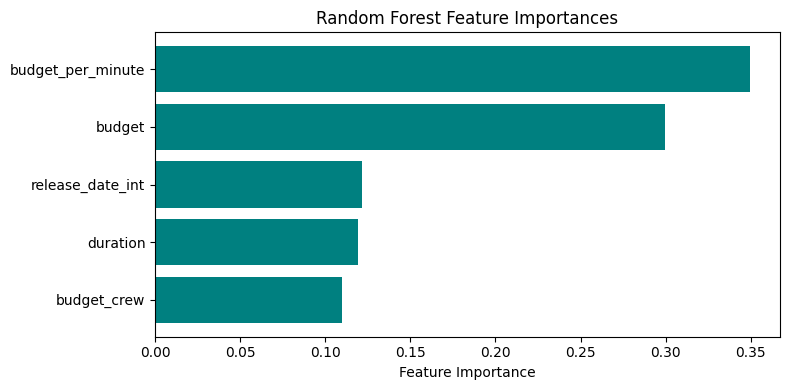

In [96]:
# Create a new feature importance plot for the random forest
import matplotlib.pyplot as plt
import pickle

# Ensure best_model is defined (load from file if not)
if 'best_model' not in locals():
	with open("random_forest_regression_uptadet.pkl", "rb") as f:
		best_model = pickle.load(f)

# Get feature importances from the best_model
importances = best_model.feature_importances_
feature_names = features

# Sort importances and feature names
indices = np.argsort(importances)
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(8, 4))
plt.barh(sorted_features, sorted_importances, color='teal')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

In [97]:
print("Genre Mapping:")
for genre, code in genre_mapping.items():
    print(f"{genre}: {code}")

    # Save the genre mapping to a CSV file
    genre_mapping_df = pd.DataFrame(list(genre_mapping.items()), columns=['Genre', 'Code'])
    genre_mapping_df.to_csv('genre_mapping.csv', index=False)
    print("Genre mapping saved to 'genre_mapping.csv'")

Genre Mapping:
Action: 1
Genre mapping saved to 'genre_mapping.csv'
Adventure: 2
Genre mapping saved to 'genre_mapping.csv'
Animation: 3
Genre mapping saved to 'genre_mapping.csv'
Comedy: 4
Genre mapping saved to 'genre_mapping.csv'
Crime: 5
Genre mapping saved to 'genre_mapping.csv'
Documentary: 6
Genre mapping saved to 'genre_mapping.csv'
Drama: 7
Genre mapping saved to 'genre_mapping.csv'
Family: 8
Genre mapping saved to 'genre_mapping.csv'
Fantasy: 9
Genre mapping saved to 'genre_mapping.csv'
History: 10
Genre mapping saved to 'genre_mapping.csv'
Horror: 11
Genre mapping saved to 'genre_mapping.csv'
Music: 12
Genre mapping saved to 'genre_mapping.csv'
Mystery: 13
Genre mapping saved to 'genre_mapping.csv'
Romance: 14
Genre mapping saved to 'genre_mapping.csv'
Science Fiction: 15
Genre mapping saved to 'genre_mapping.csv'
TV Movie: 16
Genre mapping saved to 'genre_mapping.csv'
Thriller: 17
Genre mapping saved to 'genre_mapping.csv'
War: 18


Genre mapping saved to 'genre_mapping.csv'
Western: 19
Genre mapping saved to 'genre_mapping.csv'
